In [2]:
import Pkg
Pkg.activate("../src/FE_v0.1/Project.toml")

# using Pkg; Pkg.add("Measures")
# using Pkg; Pkg.add("JLD2")
# Pkg.add("FiniteElements")

import OrdinaryDiffEq as ODE

using QuadGK
using BasicBSpline
using Random
using Distributions
using LaTeXStrings
using Plots #, CairoMakie
using PyPlot
using Printf
using SparseArrays

using FiniteElements
using Base.Threads
using Plots.PlotMeasures
using Statistics

using LinearAlgebra # identity matrix
using Turing # sampling package
using StatsPlots
using StatsBase # for defining customized distributions 
using Optim # for ML and MAP estimation 
using AdaptiveMCMC # for using adaptive MCMC sampling
using ProgressMeter # to use progress track for sampling
using Dates # to measure computational time 
using FlexiMaps # Provide flexible mapping functionalities, particularly useful for data processing tasks

using JLD2 # to save results and reuse them
using Measures

include("../src/SIACMatrix_v2.jl")
include("../src/FE_v0.1/src/DG.jl")

results_dir = "results_section_6_2"

  Activating project at `~/Desktop/UMBC/240801BayesianSIAC/code/250902code_TL/src/FE_v0.1`


"results_section_6_2"

In [3]:
# Setting up Domain Parameters
xL = -1.0       # Left Domain Boundary
xR = 1.0        # Right Domain Boundary

# Setting up the Mesh-series
# IMPORTANT: For now need numEl>=10 for the base mesh, to construct SIAC matrix!!
pMax = 3            # largest polynomial degree used (sets up DG approximation with degree 1:pMax)
refine = 4          # Number of meshes (refine=1 means the base mesh is refined once, and there are two meshes)
numEl = 3*pMax+1    # Number of Elements in Base Mesh (Choosen such that on each mesh, the filter crosses the Boundary at max once)


mesh = Array{FiniteElements.Mesh}(undef, refine) # Mesh Data structure

# Mesh Info
dim = 1
ElemsPerDim = [numEl]
mesh_vertices = [xL xR]

# Creating the meshes
for m=1:refine
    mesh[m] = build_cube_mesh(mesh_vertices, ElemsPerDim*(2^(m-1)), dim)
end

In [4]:
# Initial Condition
u0(x) = 1 + .5*sin.(pi*x) # + 0.3*cos(pi*x) - 0.4*sin(2pi*x)

# Evaluation Nodes, for which the SIAC MAtrix is constructed
Nodes = Array{Array{Float64}}(undef,refine,pMax)        # Global evaluation Points 
w_Nodes_global = Array{Array{Float64}}(undef,refine,pMax)        # Global Quadrature Weigths
Nodes_loc = Array{Array{Float64}}(undef,refine,pMax)    # Local Evaluation points
w_Nodes_local = Array{Array{Float64}}(undef,refine,pMax)        # Local Quadrature Weigths
numNodes = zeros(Int,refine,pMax)     # number of evaluation points 


xEval = Array{Array{Float64}}(undef,refine,pMax)        # Global evaluation Points 
w_global = Array{Array{Float64}}(undef,refine,pMax)        # Global Quadrature Weigths
xEval_loc = Array{Array{Float64}}(undef,refine,pMax)    # Local Evaluation points
w_local = Array{Array{Float64}}(undef,refine,pMax)        # Local Quadrature Weigths
nEval = zeros(Int,refine,pMax)     # number of evaluation points 

# Available Node types:
# "GLeg"    Gauss-Legendre nodes
# "GLob"    Gauss-Lobatto nodes
# "uni"     Equidistant nodes
# "L2"      no Interpolation, chooses L2_projection
EvalType = "L2"   


# Setting up DoF handles, for Mesh series and different polynomial degrees
uh = Array{FE}(undef, refine, pMax)     # DG data structure

# Declaring Evaluation handles
# uh_ev and u0_ev evaluate uh and u at the points prescribed in xEval.
u0_ev =  Array{Vector}(undef,refine,pMax)   # True solution (for different refinements and degrees)
uh_Nodal = Array{Vector}(undef,refine,pMax)    # DG Initial Condition (for different refinements and degrees)
uh_ev = Array{Vector}(undef,refine,pMax)    # DG Initial Condition (for different refinements and degrees)
uh_ev_pp = Array{Vector}(undef,refine,pMax) # DG Initial Condition, SIAC filtered (for different refinements and degrees)


# SIAC Matrices
F  = Array{Matrix}(undef,refine,pMax)
F_ev  = Array{Matrix}(undef,refine,pMax)

# Initializing Evaluation handles, IC and SIAC matrices
for m=1:refine
    for p=1:pMax

        if EvalType=="L2"
            Nodes[m,p], w_global[m,p], Nodes_loc[m,p], w_local[m,p] = makeNodes(mesh[m], p, type="GLeg") # Gauss-Legendre Evaluation nodes
            numNodes[m,p] = length(Nodes[m,p])

            xEval[m,p], ~, xEval_loc[m,p], ~ = makeNodes(mesh[m], 10, type="GLeg") # Gauss-Legendre Evaluation nodes
            nEval[m,p] = length(xEval[m,p])


            uh[m,p] = L2(u0, mesh[m], p, dim)
        else
            Nodes[m,p], w_global[m,p], Nodes_loc[m,p], w_local[m,p] = makeNodes(mesh[m], p, type=EvalType) # Nodes
            numNodes[m,p] = length(Nodes[m,p])

            xEval[m,p], ~, xEval_loc[m,p], ~ = makeNodes(mesh[m], 10, type="GLeg") # Gauss-Legendre Evaluation nodes
            nEval[m,p] = length(xEval[m,p])


            uh[m,p] =  Interpolate(u0, mesh[m],xEval_loc[m,p], p, dim)
        end

        uh_Nodal[m,p] = [evalFE(Nodes[m,p][j],uh[m,p]) for j=1:numNodes[m,p]]

        uh_ev[m,p] = [evalFE(xEval[m,p][j],uh[m,p]) for j=1:nEval[m,p]]
        u0_ev[m,p] = [u0(xEval[refine,pMax][j]) for j=1:nEval[refine,pMax]]

        # Initializing the SIAC matrices
        # F[m,p] is a quadratic matrix, used to postprocess uh_ev[m,p]
        # boundaryTreatment="none"      : Default, leaves near-boundary region unchanged
        # boundaryTreatment="periodic"  : Assumes periodic boundary
        F[m,p] = global_SIAC_Mat(p, mesh[m].NC[], Nodes_loc[m,p], Nodes_loc[m,p]; boundaryTreatment="periodic")    # square SIAC Matrix 
        F_ev[m,p] = global_SIAC_Mat(p, mesh[m].NC[], Nodes_loc[m,p], xEval_loc[m,p]; boundaryTreatment="periodic") # Evaluation SIAC Matrix
        uh_ev_pp[m,p] =  F_ev[m,p]*uh_Nodal[m,p]  # SIAC Filtered IC

    end
end

Projecting Data... 100%|█████████████████████████████████| Time: 0:00:00


In [5]:
# Evaluation Handles
globalDoFs = Array{Vector}(undef, refine, pMax)         # Stores the DoF of the IC. globalDoFs[m,p] are the DoFs of uh[m,p], used for time stepping
discretization = Array{Function}(undef, refine, pMax)   # The spatial (DG) discretization

# Evaluation stuff
globalDoFs_final = Array{Vector}(undef, refine, pMax)   # Stores the DoF of the final state. 
uh_Nodal_final = Array{Vector}(undef,refine,pMax)          # Evaluation points for the final state 

uh_ev_final = Array{Vector}(undef,refine,pMax)          # Evaluation points for the final state 
uh_ev_final_pp = Array{Vector}(undef,refine,pMax)       # Evaluation points for the final state 


# define the Advection velocity
alpha = [1.0]  # Advection velocity

# Declare Discretization of differential operators
M_fac = Array{Union{Diagonal{Float64, SparseVector{Float64,Int}},Factorization}}(undef, refine, pMax)        # Factorized Mass Matrix
A = Array{Matrix}(undef, refine, pMax)          # Advection + Boundary Matrix

# Assembling the spatial discretization
for m=1:refine
    for p=1:pMax

        # Uncomment to reinitialize DG-handles
        if EvalType=="L2"
            uh[m,p] = L2(u0, mesh[m], p, dim)
        else
            uh[m,p] =  Interpolate(u0, mesh[m],xEval_loc[m,p], p, dim)
        end

        # Get DoFs from DG-handle
        globalDoFs[m,p] = getDoF(uh[m,p])
        
        M = assemble_BilinearForm(uh[m,p],dim,"Base_Base")             # Mass Matrix
        K = assemble_BilinearForm(uh[m,p],dim,"Grad_Base",field=alpha) # Advection Matrix

        # (periodic) Outlet/do-nothing BC
        Bd = assembleBoundaryMatrix(uh[m,p], 2, dim) # Outlet 

        # Discrtization Matrix + factorization
        A[m,p] = (K-Bd)
        M_fac[m,p] = factorize(M)

        # Discretized PDE
        discretization[m,p] = (dummyDoF,ts) -> M_fac[m,p]\(A[m,p]*dummyDoF + prescribeBoundaryData(uh[m,p], 1, dim, x->u0(x-ts); field=alpha))
    end
end

Assembling Mass Matrix.. 100%|███████████████████████████| Time: 0:00:00
Assembling Advection Matrix (Face Contribution).. 100%|██| Time: 0:00:00


In [6]:
# Set final time
t_end = 1.0

1.0

In [7]:
# check results stored before
# jldopen("results_DG_T1.jld2", "r") do file
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r") do file
    println("Variables stored in the file:")
    println(keys(file))
end

Variables stored in the file:
["uh_ev_final", "uh_Nodal_final", "uh_ev_final_pp", "h_ref", "err", "err_pp"]


In [8]:
# Load results
@load joinpath(results_dir, "results_DG_T1.jld2") uh_ev_final uh_Nodal_final

2-element Vector{Symbol}:
 :uh_ev_final
 :uh_Nodal_final

In [9]:
# set up BCD function
using SparseArrays

function BCD_1d_scalar(F, y, R, c, d, QUIET)

    t_start = time()  # Measure time

    # Global constants and defaults
    MIN_ITER = 0
    MAX_ITER = 1000
    ABSTOL = 1e-12
    RELTOL = 1e-12

    # Data preprocessing
    m, n = size(F)  # number of (indirect) measurements and pixels
    k = size(R, 1)  # number of outputs of the regularization operator
    FtF = sparse(F' * F)  # product corresponding to the forward operator
    Fty = F' * y  # forward operator applied to the indirect data

    # Initial values for the inverse variances and the mean and others
    aalpha = 0.1
    bbeta = 1
    mu = zeros(n)
    mu_OLD = zeros(n)  # mean

    C_inv = Matrix(1.0I, n, n)

    abs_error = 0
    rel_error = 0

    if !QUIET
        println("iter\t abs error\t abs tol\t rel error\t rel tol")
    end

    # Iterate between the update steps until convergence or max number of iterations
    for counter in 1:MAX_ITER

        # 1) Fix aalpha, bbeta, and update x
        C_inv = sparse(aalpha * FtF + bbeta * R' * R)  # update covariance matrix
        mu = C_inv \ (aalpha * Fty)  # update the mean

        # 2) Fix x, B and update aalpha
        aalpha = (m + 2 * c) / (norm(F * mu - y)^2 + 2 * d)

        # 3) Fix x, aalpha and update B
        bbeta = (n + 2 * c) / (norm(R * mu)^2 + 2 * d)

        # Store certain values in history structure
        abs_error = norm(mu - mu_OLD)^2  # absolute error
        rel_error = (norm(mu - mu_OLD) / norm(mu_OLD))^2  # relative error

        mu_OLD = mu  # store value of mu

        if !QUIET
            println("$(counter)\t $(abs_error)\t $(ABSTOL)\t $(rel_error)\t $(RELTOL)")
        end

        # Check for convergence
        if abs_error < ABSTOL && rel_error < RELTOL && counter > MIN_ITER
            break
        end

    end

    # Output the time it took to perform all operations
    if !QUIET
        println("Elapsed time: ", time() - t_start, " seconds")
    end

    return mu, C_inv, aalpha, bbeta, Dict("abs_error" => abs_error, "rel_error" => rel_error)
end

BCD_1d_scalar (generic function with 1 method)

In [10]:
# For Map estimate

# initialization
fx_BCD = Array{Vector}(undef,refine,pMax)

cBCD = 1
dBCD = 1.0e-3

for m=1:refine
    for p=1:pMax
        Ffil = F[m,p]
        N = size(Ffil,1)
        FBCD = Matrix(1.0I, N, N)
        fx_noisyBCD = uh_Nodal_final[m,p]
        RBCD = Matrix(1.0I, N, N) - Ffil

        # Obtain MAP estimate using BCD algorithm
        tBCD = @elapsed begin # execution time
            # Perform MAP estimation using BCD algorithm
            fx_BCD[m,p], C_inv, aalpha, bbeta, history = BCD_1d_scalar(FBCD, fx_noisyBCD, RBCD, cBCD, dBCD, false ); 
        end
    end
end



iter	 abs error	 abs tol	 rel error	 rel tol
1	 22.49045871754478	 1.0e-12	 Inf	 1.0e-12
2	 9.559264869393632e-5	 1.0e-12	 4.250364561011137e-6	 1.0e-12
3	 2.754186022714331e-6	 1.0e-12	 1.224586897162299e-7	 1.0e-12
4	 8.997989098053433e-8	 1.0e-12	 4.000745006523131e-9	 1.0e-12
5	 2.943791353618807e-9	 1.0e-12	 1.308887310482344e-10	 1.0e-12
6	 9.627219050375894e-11	 1.0e-12	 4.280515293716425e-12	 1.0e-12
7	 3.148148804506272e-12	 1.0e-12	 1.3997499020263603e-13	 1.0e-12
8	 1.0294428025791822e-13	 1.0e-12	 4.577173913978646e-15	 1.0e-12
Elapsed time: 0.007894039154052734 seconds
iter	 abs error	 abs tol	 rel error	 rel tol
1	 33.750113669143495	 1.0e-12	 Inf	 1.0e-12
2	 4.836693176543579e-7	 1.0e-12	 1.4330894479225393e-8	 1.0e-12
3	 2.821405473449191e-13	 1.0e-12	 8.359691017096199e-15	 1.0e-12
Elapsed time: 0.00031495094299316406 seconds
iter	 abs error	 abs tol	 rel error	 rel tol
1	 44.99999854864553	 1.0e-12	 Inf	 1.0e-12
2	 9.77990252558876e-10	 1.0e-12	 2.173311742447407e-11	

In [11]:
# save more variables of interest
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r+") do file
    delete!(file, "fx_BCD") 
    write(file, "fx_BCD", fx_BCD)
end

┌ Warning: No entry named fx_BCD was found
└ @ JLD2 /Users/tongtongli/.julia/packages/JLD2/pdSa4/src/datasets.jl:397


In [12]:
# Error at the final time (as function evaluation)
eh = Array{Vector}(undef,refine,pMax)
eh_BCD = Array{Vector}(undef,refine,pMax)

# Error norm at final time
err = zeros(refine,pMax)
err_BCD = zeros(refine,pMax)

# Mesh sizes
h_ref = zeros(refine)

plot_font = "Computer Modern"
for m=1:refine
    # set reference mesh size (assuming uniform mesh)
    h_ref[m] = (mesh[m].vertices[2]-mesh[m].vertices[1])

    for p=1:pMax

        u_final = [u0(Nodes[m,p][j]-t_end) for j=1:numNodes[m,p]]

        # Compute error function
        eh[m,p] = zeros(numNodes[m,p])
        eh_BCD[m,p] = zeros(numNodes[m,p])

        for j=1:numNodes[m,p]
            eh[m,p][j] = u_final[j]-uh_Nodal_final[m,p][j]
            eh_BCD[m,p][j] = u_final[j]-fx_BCD[m,p][j]
        end

        # Compute error norm
        err[m,p] = sqrt(sum(eh[m,p].^2 .* w_global[m,p])/(mesh[m].NC[])) 
        err_BCD[m,p] = sqrt(sum(eh_BCD[m,p].^2 .* w_global[m,p])/(mesh[m].NC[]))
    end
end

In [13]:
# save more variables of interest
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r+") do file
    delete!(file, "err_BCD") 
    write(file, "err_BCD", err_BCD)
end

┌ Warning: No entry named err_BCD was found
└ @ JLD2 /Users/tongtongli/.julia/packages/JLD2/pdSa4/src/datasets.jl:397


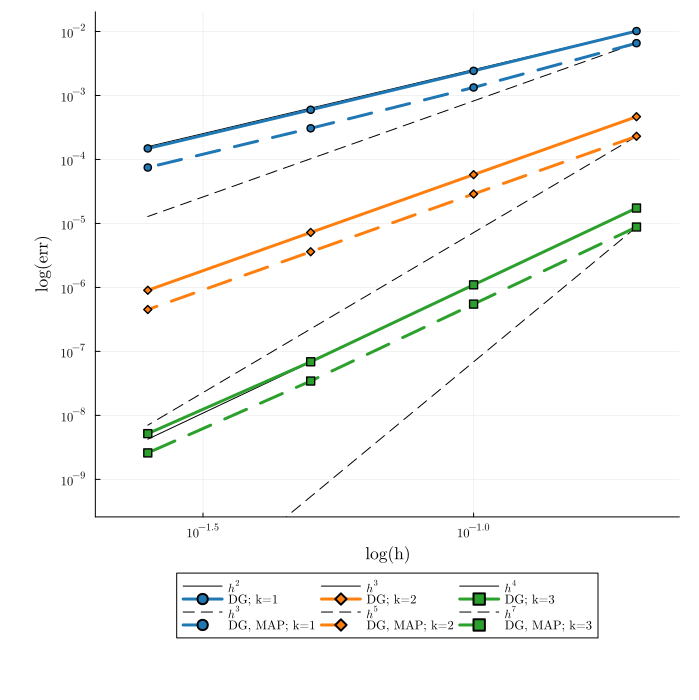

In [14]:
# Visualization of Convergence Properties
XTick = [10.0^(ll) for ll=1:-0.5:-2]
YTick = [10.0^(ll) for ll=1:-1:-12]
colors = palette(:tab10)
markers = [:circ :diamond :square]

yMax =  2*maximum([err;err_BCD])
yMin = 0.1*minimum([err;err_BCD])

xMax = 1.2*maximum(h_ref)
xMin = 0.8*minimum(h_ref)

xs = [10e-1 maximum(h_ref)]

plt = Plots.plot(yscale=:log10, 
                        yticks=YTick, 
                        ylims=(yMin, yMax),
                        xscale=:log10, 
                        xticks=XTick, 
                        xlims=(xMin, xMax),
                        xlabel="log(h)",
                        ylabel="log(err)")

for k = 1:pMax
    c1 =  (err[1,k]/h_ref[1]^(k+1)) # Constant to adjust the reference line
    Plots.plot!(h_ref[:], t-> c1*t^(k+1), color=:black, label=latexstring(" h^{$(k+1)}"))
end
for k = 1:pMax
    Plots.plot!(h_ref[:], err[:,k], color=colors[k], lw=3, marker=markers[k],label=@sprintf("DG; k=%d",k))
end

for k = 1:pMax
    c2 =  (err_BCD[1,k]/h_ref[1]^(2k+1)) # Constant to adjust the reference line
    Plots.plot!(h_ref[:], t->c2*t^(2k+1), color=:black, ls=:dash,label=latexstring(" h^{$(2k+1)}"))
end
for k = 1:pMax
    Plots.plot!(h_ref[:], err_BCD[:,k], color=colors[k], lw=3, ls=:dash, marker=markers[k], label=@sprintf("DG, MAP; k=%d",k))
end


FIG = Plots.plot(plt,
        fontfamily=plot_font, 
        legend=:outerbottom,
        size=(700,700), 
        left_margin=8mm,
        right_margin=3mm,
        bottom_margin=1mm,
        legend_columns=3) 
Plots.pdf(FIG,joinpath(results_dir, "Convergence_SIAC_T1_BCD"))
display(FIG)

### Post-processing: check errors and order of convergence

In [15]:
# check results stored before
jldopen(joinpath(results_dir, "results_DG_T1.jld2"), "r") do file
    println("Variables stored in the file:")
    println(keys(file))
end

Variables stored in the file:
["uh_ev_final", "uh_Nodal_final", "uh_ev_final_pp", "h_ref", "err", "err_pp", "fx_BCD", "err_BCD"]


In [16]:
# Load results
@load joinpath(results_dir, "results_DG_T1.jld2") h_ref err_BCD

2-element Vector{Symbol}:
 :h_ref
 :err_BCD

In [17]:
refine = 4

4

In [18]:
println("Errors for p=1:")
for m in 1:refine
    println("m=$m, h=$(h_ref[m]): err=$(err_BCD[m, 1])")
end

Errors for p=1:
m=1, h=0.19999999999999996: err=0.006569194776238559
m=2, h=0.09999999999999998: err=0.0013327820607647914
m=3, h=0.050000000000000044: err=0.0003067662608486884
m=4, h=0.025000000000000022: err=7.484061990106998e-5


In [19]:
orders = zeros(refine-1)
for m in 1:refine-1
    e1, e2 = err_BCD[m,1], err_BCD[m+1,1]
    h1, h2 = h_ref[m], h_ref[m+1]
    orders[m] = log(e1/e2) / log(h1/h2)
end

In [20]:
println("\nEstimated orders of convergence (between consecutive mesh refinements):")
for m in 1:refine-1
    println("Between m=$m and m=$(m+1): order=$(orders[m])")
end


Estimated orders of convergence (between consecutive mesh refinements):
Between m=1 and m=2: order=2.301275654721621
Between m=2 and m=3: order=2.1192291628991478
Between m=3 and m=4: order=2.035246405761124
